<a href="https://colab.research.google.com/github/ymuto0302/RW2025/blob/main/MLP_SpiralDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## データセットの生成
人工的にスパイラルデータセットを生成する。

**データセットの特徴：**
- サンプル数：3,000個 (1,000個／クラス)
- 特徴量の数：2
- クラス数：3 （ラベル：0~2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

def generate_spiral_data(n_samples=1000, n_classes=3, noise=0.2):
    """
    スパイラルデータを生成

    Args:
        n_samples: クラスごとのサンプル数
        n_classes: クラス数
        noise: ノイズの強さ
    """
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype=int)

    for class_idx in range(n_classes):
        # 各クラスの開始インデックス
        idx = range(n_samples * class_idx, n_samples * (class_idx + 1))

        # 半径（内側から外側へ）
        r = np.linspace(0.0, 1, n_samples)

        # 角度（渦巻き状に回転）
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, n_samples) + \
            np.random.randn(n_samples) * noise

        # 極座標から直交座標へ変換
        X[idx] = np.c_[r * np.sin(t * 2.5), r * np.cos(t * 2.5)]
        y[idx] = class_idx

    return X, y

# データの生成
X, y = generate_spiral_data(n_samples=1000, n_classes=3, noise=0.2)

### (参考) データの可視化

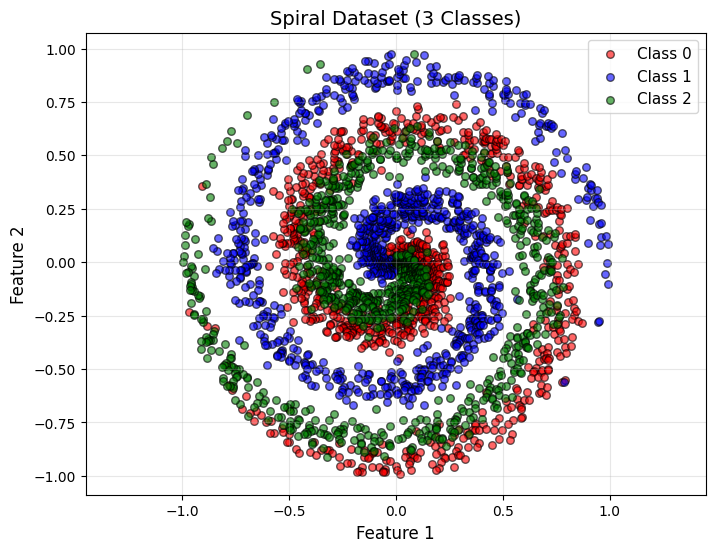

In [3]:
# 可視化
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']
for i in range(3):
    mask = y == i
    plt.scatter(X[mask, 0], X[mask, 1], c=colors[i],
                label=f'Class {i}', alpha=0.6, edgecolors='k', s=30)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Spiral Dataset (3 Classes)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## データの分割 ＆ テンソル化
データを訓練セットとテストセットに分割する。その後， `torch.FloatTensor()` と `torch.LongTensor()` を用いてテンソル化する。

In [4]:
# データの分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# デバイス設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# テンソル化
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

## MLPモデルの実装
外部から活性化関数を指定できるよう，引数 `activation` が追加されている。

In [5]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, activation='relu'):
        super(MultiLayerPerceptron, self).__init__()

        layers = []
        prev_size = input_size

        # 隠れ層の構築
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))

            # 活性化関数
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())

            prev_size = hidden_size

        # 出力層
        layers.append(nn.Linear(prev_size, output_size))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

    def predict(self, x):
        with torch.no_grad():
            outputs = self.network(x)
            # 確率最大のクラスを取り出す
            _, predicted = torch.max(outputs.data, 1)
            return predicted

## モデルを学習するための関数
外部から学習率を指定できるよう，引数 `lr` が追加されている。

In [16]:
# モデルを学習するための関数
def train_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 学習履歴の保存
    train_losses = []
    test_accuracies = []

    # データサイズとバッチ数
    n_samples = len(X_train) # 訓練サンプル数
    n_batches = (n_samples + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train() # 学習モードに設定
        epoch_loss = 0.0

        # ミニバッチ学習  (注)手動でバッチを作成する
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)

            # バッチデータの取得
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝播
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # 逆伝播
            loss.backward()
            optimizer.step()

            # 損失の累積
            epoch_loss += loss.item()

        # エポック毎の平均損失を記録
        avg_loss = epoch_loss / n_batches
        train_losses.append(avg_loss)

        # テストデータでの精度評価
        model.eval() # 評価モードに設定
        with torch.no_grad():
            # 予測
            predicted = model.predict(X_test)
            test_accuracy = (predicted == y_test).float().mean().item()
            test_accuracies.append(test_accuracy)

        # 進捗表示
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss={avg_loss:.4f}, Test Accuracy={test_accuracy:.4f}')

    return train_losses, test_accuracies

In [17]:

# 異なる深さのMLPを比較
architectures = [
    ('浅いMLP (16,)', (16,)),
    ('中くらいのMLP (32, 16)', (32, 16)),
    ('深いMLP (64, 32, 16)', (64, 32, 16)),
    ('とても深いMLP (128, 64, 32, 16)', (128, 64, 32, 16))
]

results = []

for name, hidden_sizes in architectures:
    print(f"\n=== {name}の訓練 ===")
    model = MultiLayerPerceptron(2, hidden_sizes, 3, activation='relu').to(device)

    losses, test_accs = train_model(
        model, X_train_tensor, y_train_tensor,
        X_test_tensor, y_test_tensor, epochs=200
    )

    results.append({
        'name': name,
        'final_test_acc': test_accs[-1],
        'model': model
    })

    # 決定境界の可視化
    # plot_decision_boundary(model, X_test, y_test, f'{name}の決定境界')

# 結果の比較
print("\n\n=== 結果の比較 ===")
for result in results:
    print(f"{result['name']}: テスト精度={result['final_test_acc']:.4f}")


=== 浅いMLP (16,)の訓練 ===
Epoch [50/200], Loss=0.8540, Test Accuracy=0.5844
Epoch [100/200], Loss=0.7715, Test Accuracy=0.6133
Epoch [150/200], Loss=0.7297, Test Accuracy=0.6133
Epoch [200/200], Loss=0.7081, Test Accuracy=0.6156

=== 中くらいのMLP (32, 16)の訓練 ===
Epoch [50/200], Loss=0.3266, Test Accuracy=0.8700
Epoch [100/200], Loss=0.2834, Test Accuracy=0.8811
Epoch [150/200], Loss=0.2650, Test Accuracy=0.8878
Epoch [200/200], Loss=0.2661, Test Accuracy=0.8800

=== 深いMLP (64, 32, 16)の訓練 ===
Epoch [50/200], Loss=0.3229, Test Accuracy=0.8700
Epoch [100/200], Loss=0.2734, Test Accuracy=0.8756
Epoch [150/200], Loss=0.2656, Test Accuracy=0.8711
Epoch [200/200], Loss=0.2411, Test Accuracy=0.8744

=== とても深いMLP (128, 64, 32, 16)の訓練 ===
Epoch [50/200], Loss=0.2886, Test Accuracy=0.8622
Epoch [100/200], Loss=0.2568, Test Accuracy=0.8722
Epoch [150/200], Loss=0.2412, Test Accuracy=0.8644
Epoch [200/200], Loss=0.2353, Test Accuracy=0.8700


=== 結果の比較 ===
浅いMLP (16,): テスト精度=0.6156
中くらいのMLP (32, 16): テスト